In [1]:
#imports
import logging
import torch
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression
import matplotlib.pyplot as plt

from sk_models import PLSRegression, StandardScaler,LocalWeightedRegression,PLSLWR,LinearRidge
from river_models import *

from river import stream,linear_model,preprocessing, ensemble, metrics, optim
from river.neighbors import KNNRegressor 
from sklearn.metrics import mean_squared_error
from river.utils import dict2numpy, numpy2dict

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and output directories

#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "PLN7.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =["db_id","sample_id"] #
output_cols = None
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/5.03_v2") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\5.03_v2\PLN7


In [3]:
data = pd.read_csv(data_file)
data=data.sample(frac=1,random_state=random_state)

pre_ind =[i for i in range(0,10000)]
pretrain_ind,pretest_ind = train_test_split(pre_ind,train_size=5/6,random_state=random_state,shuffle=False)
stream_ind = [i for i in range(10000,110000)]

pretrain_data =  ut.TabularDataset(data.iloc[pretrain_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
pretest_data = ut.TabularDataset(data.iloc[pretest_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
stream_data = ut.TabularDataset(data.iloc[stream_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

nrow, ncol = data.shape
nrow_train = len(pretrain_data)
nrow_test = len(pretest_data)
nrow_stream = len(stream_data)

print(f"train: {nrow_train}, test: {nrow_test}, stream: {nrow_stream}")

train: 8333, test: 1667, stream: 100000


In [4]:
deep_model_dir = Path("D:/workspace/lazydeep/experiments/1.01/PLN7")
pls_deep_model = torch.load(deep_model_dir/"models"/"random_82"/"_model")
pls_deep_model.load_state(deep_model_dir/"models"/"random_82"/"_final")
pls_scaler = PLSRegression(n_components=34).from_state(PLSRegression(n_components=34).load_state(deep_model_dir/'preprocessing'/f"_final"))                       
pls_deep_lwr = StreamLocalWeightedRegression(n_neighbors=1000,floor=True)


#stream_pls_deep = StreamDeep(pls_scaler,pls_deep_model)
#stream_pls_deep_lwr = StreamDeepLWR(pls_scaler,pls_deep_model,pls_deep_lwr)
stream_pls_deep = (StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model))
stream_pls_deep_lwr = (StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model)|preprocessing.StandardScaler()|StreamLocalWeightedRegression(n_neighbors=1000,floor=True))
                          
deep_model_dir = Path("D:/workspace/lazydeep/experiments/2.00/PLN7")
deep_model = torch.load(deep_model_dir/"models"/"random_29"/"_model")
deep_model.load_state(deep_model_dir/"models"/"random_29"/"_final")
deep_scaler = StandardScaler().from_state(StandardScaler().load_state(deep_model_dir/'preprocessing'/f"_final"))                
                      
deep_lwr = StreamLocalWeightedRegression(n_neighbors=1000,floor=True)

#stream_deep = StreamDeep(deep_scaler,deep_model)
#stream_deep_lwr = StreamDeepLWR(deep_scaler,deep_model,deep_lwr)
stream_deep = (StreamWrapper(deep_scaler)|StreamDeep(deep_model))
stream_deep_lwr = (StreamWrapper(deep_scaler)|StreamDeep(deep_model)|preprocessing.StandardScaler()|StreamLocalWeightedRegression(n_neighbors=1000,floor=True))

river_models = {'deep':stream_deep,
               'deep_lwr':stream_pls_deep_lwr,
               'pls_deep':stream_pls_deep,
               'pls_deep_lwr':stream_deep_lwr}

In [5]:
#setup our metrics and stores of results
full_set = river_models.keys()
metrics = {'R2':{name:metrics.R2() for name in full_set},
           'R2_rolling':{name:metrics.Rolling(metrics.R2(), window_size=1000) for name in full_set},
           'MSE':{name:metrics.MSE() for name in river_models.keys()},
           'MSE_rolling':{name:metrics.Rolling(metrics.MSE(), window_size=1000) for name in full_set}
          }
    


In [6]:
#so sofar we have establish our metrics and scores are correct
from tqdm.notebook import tqdm, trange

In [7]:
#take our pretrained models, now evaluate them on 

In [8]:
_,_,river_models,metrics = prequential_evaluate(pretrain_data,river_models,metrics,pretrain = len(pretrain_data),num_its=len(pretrain_data))

  0%|          | 0/8333 [00:00<?, ?it/s]

In [9]:
preds_test,scores_test,metrics = score_evaluate(pretest_data,river_models,metrics,num_its=len(pretest_data))

  0%|          | 0/1667 [00:00<?, ?it/s]

In [10]:
preds_stream, scores_stream,river_models,metrics = prequential_evaluate(stream_data,river_models,metrics,pretrain=0,num_its=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
def zip_dict(dict1,dict2):

    dict12 = {k:dict1[k]+dict2[k] for k in dict1.keys()}   
    return dict12

def zip_nested_dict(dict1,dict2):
    dict12 = {}
    
    for k in dict1.keys():
        dict12[k] = {name:dict1[k][name]+dict2[k][name] for name in dict1[k].keys()}
    return dict12

In [12]:
preds = zip_dict(preds_test,preds_stream)

In [13]:
scores = zip_nested_dict(scores_test,scores_stream)

In [14]:
preds_df = pd.DataFrame(preds)
preds_df.to_csv(log_dir/"preds_df.csv")


In [15]:
#findings
#1) preprocessing works, random lr things for lr don't
#) standardisation asks as regularisation

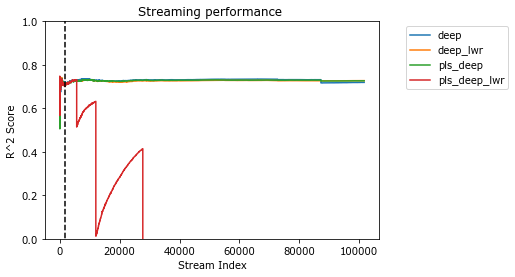

In [16]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['R2'])
scores_df.to_csv(log_dir/"r2_scores.csv")
for (columnName, columnData) in scores_df.iteritems():

    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2.png",bbox_inches='tight')


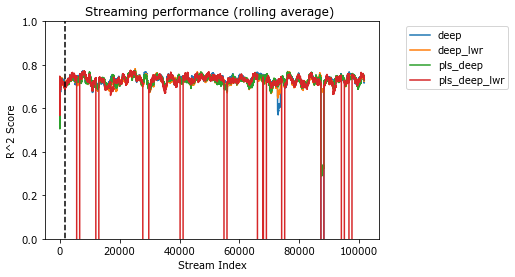

In [17]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance (rolling average) ")
    
scores_df = pd.DataFrame(scores['R2_rolling'])
scores_df.to_csv(log_dir/"r2_scores_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    columnData
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2.png",bbox_inches='tight')

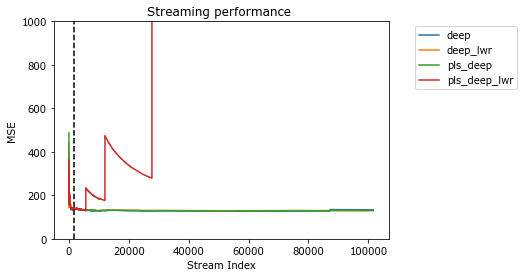

In [18]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['MSE'])
scores_df.to_csv(log_dir/"MSE.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot.png",bbox_inches='tight')
ax.set_ylim(0,1000)
plt.savefig(log_dir / f"mse_plot_v2.png",bbox_inches='tight')

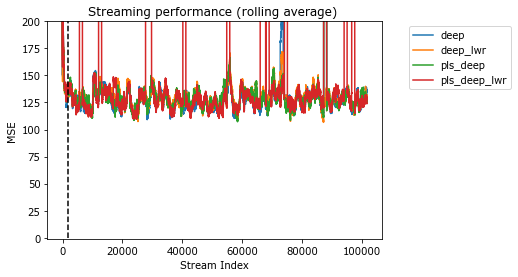

In [19]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance (rolling average) ")

scores_df = pd.DataFrame(scores['MSE_rolling'])
scores_df.to_csv(log_dir/"MSE_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(-1,200)
plt.savefig(log_dir / f"mse_plot_rolling_v2.png",bbox_inches='tight')

deep, R^2 = 0.848769706128346, MSE = 133.40601677494345
deep_lwr, R^2 = 0.8530125927674694, MSE = 129.58412693458374
pls_deep, R^2 = 0.8527890291740743, MSE = 129.96290114835926
pls_deep_lwr, R^2 = 0.3072194070987319, MSE = 2658.826096343664


(-500.0, 500.0)

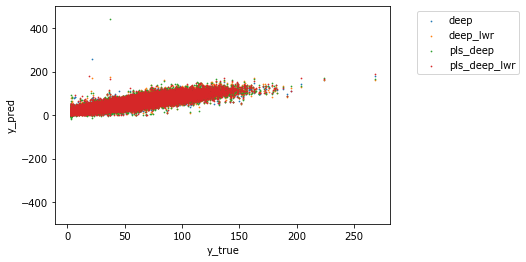

In [20]:
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

fig, ax = plt.subplots()
ax.set_ylabel('y_pred')
ax.set_xlabel('y_true')

for (columnName, columnData) in preds_df.iteritems():
        if not columnName == 'y':
            ax.scatter(preds_df['y'],columnData,label = f"{columnName}",s=0.5)
            
            corr_coef = scipy.stats.pearsonr(columnData, preds_df['y'])
            #slope, intercept, r, p, stderr = scipy.stats.linregress(columnData, preds_df['y'])
            loss = mean_squared_error(preds_df['y'], columnData)
            mae = mean_absolute_error(preds_df['y'], columnData)    
            print(f"{columnName}, R^2 = {corr_coef[0]}, MSE = {loss}")
            
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylim(-500,500)

In [21]:
deep_model = {i:deepcopy(deep_model) for i in range(0,10)}
configs = {i:1e-i for i in range(0,10)
opts = {}

SyntaxError: invalid decimal literal (2131398135.py, line 2)